In [1]:
!nvidia-smi

Fri Aug 23 20:11:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -q roboflow
!pip install -q git+https://github.com/roboflow/supervision.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("ai-flooring-model-mid").project("walls-segmentation-detection")
version = project.version(12)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...
Exporting format paligemma in progress : 85.0%
Version export complete for paligemma format



Extracting Dataset Version Zip to Walls-Segmentation-(Detection)-12 in paligemma:: 100%|██████████| 709/709 [00:00<00:00, 7085.39it/s]


In [4]:
!head -n 5 "{dataset.location}/dataset/_annotations.train.jsonl"

{"image":"203_png.rf.c366f684adf6548dd252b7ad290b6bca.jpg","prefix":"detect Wall","suffix":"<loc0815><loc0538><loc0877><loc0794> Wall ; <loc0808><loc0229><loc0877><loc0483> Wall ; <loc0527><loc0229><loc0655><loc0243> Wall ; <loc0098><loc0230><loc0376><loc0794> Wall ; <loc0527><loc0779><loc0661><loc0792> Wall ; <loc0708><loc0449><loc0853><loc0457> Wall ; <loc0707><loc0565><loc0854><loc0574> Wall ; <loc0541><loc0244><loc0634><loc0459> Wall ; <loc0543><loc0566><loc0632><loc0779> Wall ; <loc0299><loc0244><loc0465><loc0458> Wall ; <loc0299><loc0516><loc0465><loc0573> Wall"}
{"image":"13_png.rf.c4161b209494f2a23dffdeb9ea4ae05a.jpg","prefix":"detect Wall","suffix":"<loc0102><loc0172><loc0856><loc0851> Wall ; <loc0272><loc0303><loc0342><loc0317> Wall ; <loc0119><loc0303><loc0190><loc0317> Wall ; <loc0120><loc0487><loc0268><loc0500> Wall ; <loc0244><loc0634><loc0438><loc0711> Wall ; <loc0351><loc0425><loc0560><loc0514> Wall ; <loc0499><loc0318><loc0517><loc0363> Wall ; <loc0284><loc0774><loc030

In [5]:
!head -n 5 "{dataset.location}/dataset/_annotations.valid.jsonl"

{"image":"63_png.rf.520d8d3b6eacb0d18edeade38ee9deb6.jpg","prefix":"detect Wall","suffix":"<loc0130><loc0613><loc0319><loc0947> Wall ; <loc0129><loc0076><loc0217><loc0389> Wall ; <loc0321><loc0076><loc0892><loc0493> Wall ; <loc0501><loc0631><loc0894><loc0946> Wall ; <loc0147><loc0274><loc0221><loc0285> Wall ; <loc0318><loc0273><loc0392><loc0285> Wall ; <loc0146><loc0696><loc0478><loc0708> Wall ; <loc0576><loc0696><loc0685><loc0934> Wall ; <loc0783><loc0696><loc0878><loc0708> Wall"}
{"image":"148_png.rf.153a431a5cc2f3c19f472eb60ea62386.jpg","prefix":"detect Wall","suffix":"<loc0118><loc0212><loc0870><loc0811> Wall ; <loc0132><loc0223><loc0855><loc0800> Wall ; <loc0132><loc0499><loc0855><loc0799> Wall ; <loc0561><loc0224><loc0855><loc0511> Wall"}
{"image":"180_png.rf.529ab1ae6685e0b199818d0378b47561.jpg","prefix":"detect Wall","suffix":"<loc0101><loc0299><loc0921><loc0725> Wall ; <loc0662><loc0485><loc0910><loc0558> Wall ; <loc0668><loc0428><loc0679><loc0443> Wall ; <loc0330><loc0522><lo

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings:

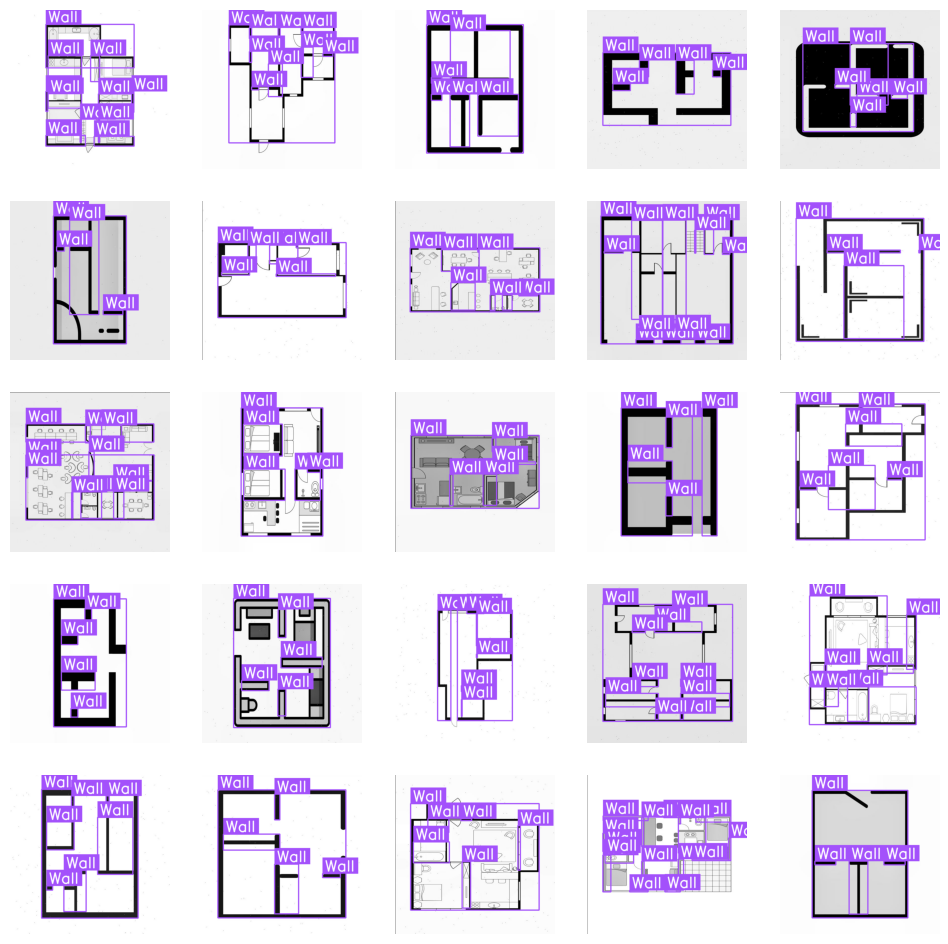

In [6]:
import cv2
import json
import supervision as sv
from typing import List

def read_n_lines(file_path: str, n: int) -> List[str]:
    with open(file_path, 'r') as file:
        lines = [next(file).strip() for _ in range(n)]
    return lines

images = []
lines = read_n_lines(f"{dataset.location}/dataset/_annotations.train.jsonl", 25)
first = json.loads(lines[0])

CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")

for line in lines:
    data = json.loads(line)
    image = cv2.imread(f"{dataset.location}/dataset/{data.get('image')}")
    (h, w, _) = image.shape
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=data.get('suffix'),
        resolution_wh=(w, h),
        classes=CLASSES)

    image = sv.BoundingBoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

In [7]:
print(sv.__version__)  # Print the version of supervision
print(dir(sv))  # Print all attributes and classes available in supervision


0.22.0
['BackgroundOverlayAnnotator', 'BaseDataset', 'BlurAnnotator', 'BoundingBoxAnnotator', 'BoxAnnotator', 'BoxCornerAnnotator', 'ByteTrack', 'CSVSink', 'CircleAnnotator', 'ClassificationDataset', 'Classifications', 'Color', 'ColorAnnotator', 'ColorLookup', 'ColorPalette', 'ConfusionMatrix', 'CropAnnotator', 'DetectionDataset', 'Detections', 'DetectionsSmoother', 'DotAnnotator', 'EdgeAnnotator', 'EllipseAnnotator', 'FPSMonitor', 'HaloAnnotator', 'HeatMapAnnotator', 'ImageSink', 'InferenceSlicer', 'JSONSink', 'KeyPoints', 'LMM', 'LabelAnnotator', 'LineZone', 'LineZoneAnnotator', 'MaskAnnotator', 'MeanAveragePrecision', 'OrientedBoxAnnotator', 'OverlapFilter', 'PercentageBarAnnotator', 'PixelateAnnotator', 'Point', 'PolygonAnnotator', 'PolygonZone', 'PolygonZoneAnnotator', 'Position', 'Rect', 'RichLabelAnnotator', 'RoundBoxAnnotator', 'TraceAnnotator', 'TriangleAnnotator', 'VertexAnnotator', 'VertexLabelAnnotator', 'VideoInfo', 'VideoSink', '__builtins__', '__cached__', '__doc__', '__

In [8]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [9]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [10]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


In [11]:
import os
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [01:31<00:00, 63.9MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


In [12]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())


In [13]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [14]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))


def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

In [15]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.train.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.valid.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


In [16]:
def split_and_keep_second_part(s):
    parts = s.split('\n', 1)
    if len(parts) > 1:
        return parts[1]
    return s

def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
    image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(
            lmm='paligemma',
            result=caption,
            resolution_wh=(w, h),
            classes=CLASSES)
        image = sv.BoundingBoxAnnotator().annotate(image, detections)
        image = sv.LabelAnnotator().annotate(image, detections)
    except:
        print(caption)
    return f"""


    {html.escape(caption)}

"""

html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = split_and_keep_second_part(caption)
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

Training examples


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [17]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []

  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

In [18]:
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=4, batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [19]:
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.005

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, _, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))

step:  1/64   lr: 0.00083   loss: 3.7647
step:  2/64   lr: 0.00167   loss: 3.7481
step:  3/64   lr: 0.00250   loss: 3.3590
step:  4/64   lr: 0.00333   loss: 3.3091
step:  5/64   lr: 0.00417   loss: 3.3575
step:  6/64   lr: 0.00500   loss: 3.1788
step:  7/64   lr: 0.00500   loss: 3.2726
step:  8/64   lr: 0.00499   loss: 3.0913
Model predictions at step 8


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


step:  9/64   lr: 0.00497   loss: 3.0276
step: 10/64   lr: 0.00494   loss: 3.3604
step: 11/64   lr: 0.00491   loss: 2.9727
step: 12/64   lr: 0.00487   loss: 2.9980
step: 13/64   lr: 0.00483   loss: 2.9236
step: 14/64   lr: 0.00478   loss: 3.0791
step: 15/64   lr: 0.00472   loss: 3.0370
step: 16/64   lr: 0.00465   loss: 2.8693
Model predictions at step 16


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


step: 17/64   lr: 0.00458   loss: 2.8917
step: 18/64   lr: 0.00451   loss: 2.7730
step: 19/64   lr: 0.00442   loss: 2.7715
step: 20/64   lr: 0.00434   loss: 2.8645
step: 21/64   lr: 0.00424   loss: 3.1448
step: 22/64   lr: 0.00415   loss: 2.7704
step: 23/64   lr: 0.00404   loss: 2.8947
step: 24/64   lr: 0.00394   loss: 2.7857
Model predictions at step 24


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


step: 25/64   lr: 0.00383   loss: 3.0338
step: 26/64   lr: 0.00371   loss: 2.6830
step: 27/64   lr: 0.00359   loss: 2.8923
step: 28/64   lr: 0.00347   loss: 2.8068
step: 29/64   lr: 0.00335   loss: 2.9364
step: 30/64   lr: 0.00322   loss: 2.8438
step: 31/64   lr: 0.00309   loss: 2.6711
step: 32/64   lr: 0.00296   loss: 2.6248
Model predictions at step 32


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


step: 33/64   lr: 0.00283   loss: 2.6840
step: 34/64   lr: 0.00270   loss: 2.7583
step: 35/64   lr: 0.00257   loss: 2.7032
step: 36/64   lr: 0.00243   loss: 2.4961
step: 37/64   lr: 0.00230   loss: 2.8176
step: 38/64   lr: 0.00217   loss: 2.8726
step: 39/64   lr: 0.00204   loss: 2.4872
step: 40/64   lr: 0.00191   loss: 2.6577
Model predictions at step 40


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


step: 41/64   lr: 0.00178   loss: 2.7264
step: 42/64   lr: 0.00165   loss: 2.4045
step: 43/64   lr: 0.00153   loss: 2.5077
step: 44/64   lr: 0.00141   loss: 2.3755
step: 45/64   lr: 0.00129   loss: 2.5857
step: 46/64   lr: 0.00117   loss: 2.6617
step: 47/64   lr: 0.00106   loss: 2.7969
step: 48/64   lr: 0.00096   loss: 2.7017
Model predictions at step 48


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


step: 49/64   lr: 0.00085   loss: 2.4914
step: 50/64   lr: 0.00076   loss: 2.6311
step: 51/64   lr: 0.00066   loss: 2.6151
step: 52/64   lr: 0.00058   loss: 2.8055
step: 53/64   lr: 0.00049   loss: 2.7148
step: 54/64   lr: 0.00042   loss: 2.4698
step: 55/64   lr: 0.00035   loss: 2.5867
step: 56/64   lr: 0.00028   loss: 2.4710
Model predictions at step 56


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


step: 57/64   lr: 0.00022   loss: 2.6099
step: 58/64   lr: 0.00017   loss: 2.7504
step: 59/64   lr: 0.00013   loss: 2.4615
step: 60/64   lr: 0.00009   loss: 2.5219
step: 61/64   lr: 0.00006   loss: 2.7962
step: 62/64   lr: 0.00003   loss: 2.5829
step: 63/64   lr: 0.00001   loss: 2.5726
step: 64/64   lr: 0.00000   loss: 2.6980
Model predictions at step 64


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


CPU times: user 3min 50s, sys: 973 ms, total: 3min 51s
Wall time: 1min 21s


In [20]:
# @title Visualize results
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=16, batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings:

In [21]:
# @title Collect predictions
targets = []
predictions = []

for image, label, prediction in make_predictions(validation_data_iterator(), num_examples=512, batch_size=8):
    h, w, _ = image.shape
    target = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label,
        resolution_wh=(w, h),
        classes=CLASSES)
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm='paligemma',
        result=prediction,
        resolution_wh=(w, h),
        classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)


In [22]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.00
map50: 0.00
map75: 0.00


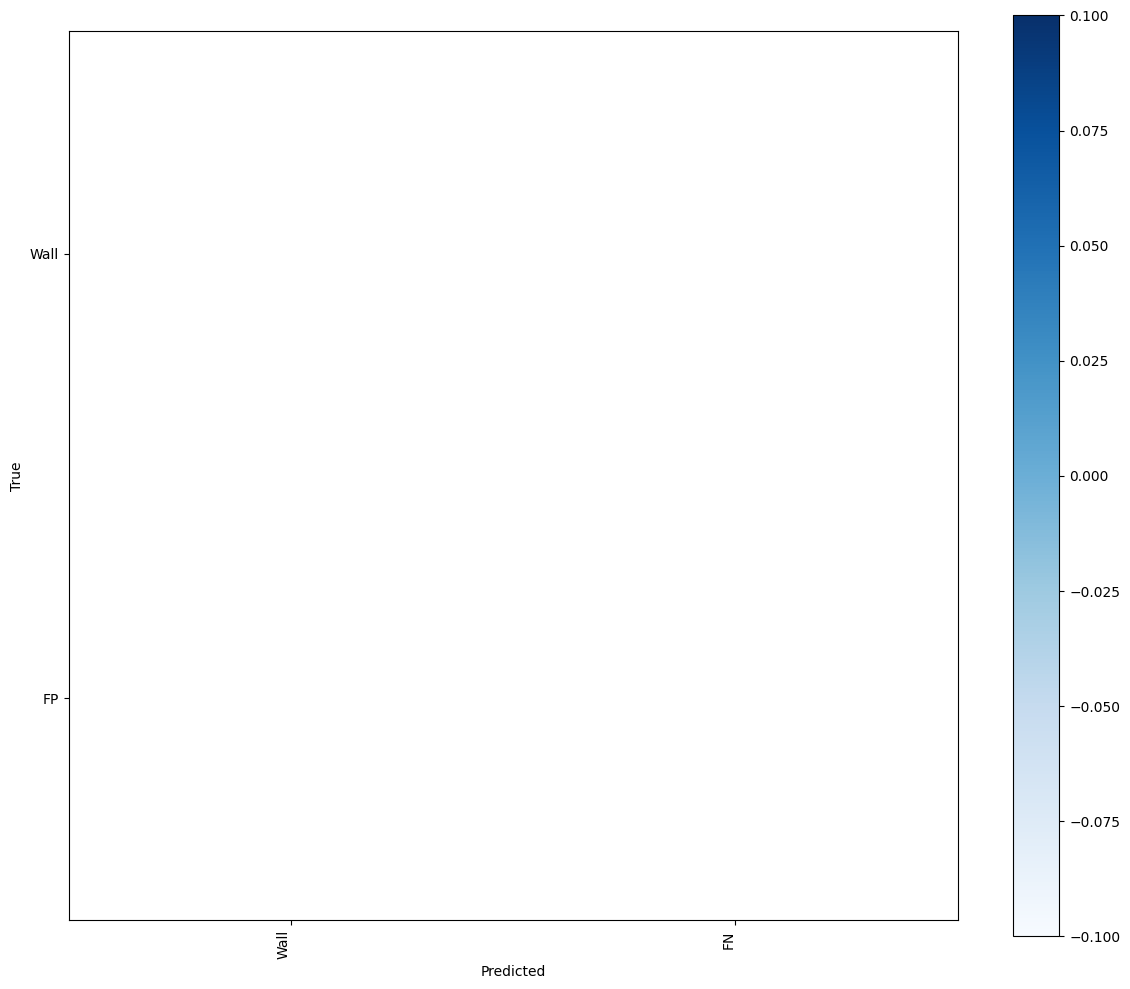

In [23]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [24]:
import os

TARGET_MODEL_DIR = f"{dataset.location}/model"
TARGET_MODEL_PATH = f"{TARGET_MODEL_DIR}/paligemma-3b-pt-224.f16.npz"

os.makedirs(TARGET_MODEL_DIR, exist_ok=True)

In [25]:
flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open(TARGET_MODEL_PATH, "wb") as f:
  np.savez(f, **{k: v for k, v in flat})

In [26]:
flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open(TARGET_MODEL_PATH, "wb") as f:
  np.savez(f, **{k: v for k, v in flat})

In [27]:
version.deploy(model_type="paligemma-3b-pt-224", model_path=TARGET_MODEL_DIR)

Model files found in /content/Walls-Segmentation-(Detection)-12/model: ['paligemma-3b-pt-224.f16.npz']
Found .npz file paligemma-3b-pt-224.f16.npz in model path. Deploying JAX PaliGemma model.
Zipping files for deploy: ['paligemma-3b-pt-224.f16.npz']
Uploading to Roboflow... May take several minutes.
View the status of your deployment at: https://app.roboflow.com/ai-flooring-model-mid/walls-segmentation-detection/12
